In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset/Pretraining stuff

In [ ]:
labels = np.load('/content/drive/My Drive/Colab Notebooks/labels.npy')
audios = np.load('/content/drive/My Drive/Colab Notebooks/audios.npy')

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
import scipy
from scipy import signal, fft
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1


In [ ]:
# https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

def spectrogram(samples, sample_rate=44100, stride_ms = 20.0, 
                          window_ms = 40.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [ ]:
test = audios[0]

In [ ]:
import librosa
import librosa.display

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
sr = 44100
# A2S = Audio sequence to spectrogram

# Dont convert to 64x64

def a2s(audio_sequence, sampling_rate=sr):
    cut_audio = audio_sequence#[audio_sequence!=0]

    spec = spectrogram(cut_audio, sample_rate = sampling_rate, max_freq = 11025)
    return spec

In [ ]:
# Uncut audios
import time

start = time.time()
specs = np.apply_along_axis(a2s, 1, audios)

print(time.time() - start)

17.207181930541992


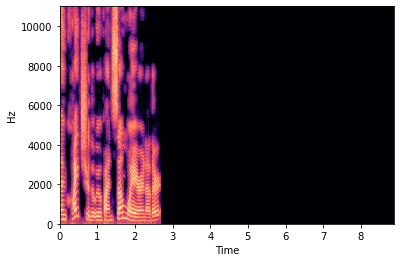

In [ ]:
librosa.display.specshow(specs[200], sr=22000, x_axis='time', y_axis='hz')

In [ ]:
specs.shape
from keras.callbacks import History

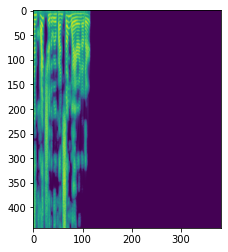

In [ ]:
plt.imshow(specs[200])

In [ ]:

mask = np.logical_or(labels=='other', labels=='X')

labels = labels[~mask]
specs = specs[~mask]

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

np.sum(label_binarize(labels, classes=['angry', 'happy', 'sad', 'neutral']), axis=0)

array([284, 224, 186, 524])

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(specs, labels, test_size=0.25)

y_bin = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral',])
y_bin2 = label_binarize(y_test, classes=['angry', 'happy', 'sad', 'neutral',])


In [ ]:
def plothist(hist):
      plt.plot(hist.history['loss'])
      plt.plot(hist.history['val_loss'])
      plt.title('Model Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper right')
      plt.show()

      plt.plot(hist.history['accuracy'])
      plt.plot(hist.history['val_accuracy'])
      plt.title('Model Accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper right')
      plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

In [ ]:
def create_model(num_filters_1, num_filters_2, dense_units, dropout_rate, l1_reg):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(221, 1537, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
np.sum(y_bin, axis=0)

array([210, 176, 135, 392])

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=720)

In [ ]:
y_train_val = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral',])

# Data Aug

In [ ]:
np.sum(y_train_val, axis=0)

array([186, 119, 107, 318])

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy={'angry': 200, 'happy': 200, 'sad': 200})

In [ ]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], -1))

In [ ]:
X_train_aug, y_train_aug = oversample.fit_resample(X_train_reshaped, y_train)

In [ ]:
specs_aug = X_train_aug.reshape(X_train_aug.shape[0], 221, 1537)

In [ ]:
y_bin_aug = label_binarize(y_train_aug, classes=['angry', 'happy', 'sad', 'neutral',])

In [ ]:
np.sum(y_bin_aug, axis=0)

array([200, 200, 200, 318])

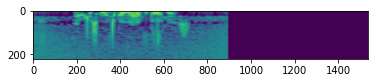

In [ ]:
plt.imshow(specs_aug[900])

In [ ]:
y_val_bin = label_binarize(y_val, classes=['angry', 'happy', 'sad', 'neutral',])

# Training aug

In [ ]:
history = History()
model = create_model(16, 16, 256, 0.2, 0.001)
model.fit(X_train, y_bin, epochs=25, batch_size=32, verbose=1, shuffle=True,validation_split=0.2, callbacks=[history])

Epoch 1/25
24/24 [==============================] - 15s 202ms/step - loss: 622.0302 - accuracy: 0.2687 - val_loss: 178.6600 - val_accuracy: 0.2094
Epoch 2/25
24/24 [==============================] - 3s 126ms/step - loss: 167.3264 - accuracy: 0.3408 - val_loss: 151.4351 - val_accuracy: 0.4503
Epoch 3/25
24/24 [==============================] - 3s 127ms/step - loss: 136.9185 - accuracy: 0.4666 - val_loss: 121.4247 - val_accuracy: 0.4398
Epoch 4/25
24/24 [==============================] - 3s 128ms/step - loss: 110.0866 - accuracy: 0.5177 - val_loss: 98.4873 - val_accuracy: 0.4660
Epoch 5/25
24/24 [==============================] - 3s 127ms/step - loss: 89.2053 - accuracy: 0.5177 - val_loss: 80.2493 - val_accuracy: 0.4921
Epoch 6/25
24/24 [==============================] - 3s 129ms/step - loss: 72.8620 - accuracy: 0.5439 - val_loss: 65.7781 - val_accuracy: 0.4712
Epoch 7/25
24/24 [==============================] - 3s 127ms/step - loss: 59.7253 - accuracy: 0.5609 - val_loss: 54.1961 - val_a

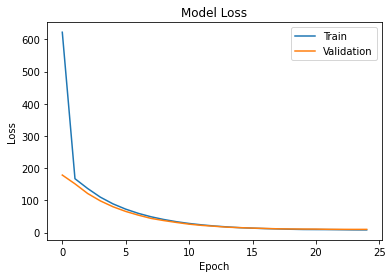

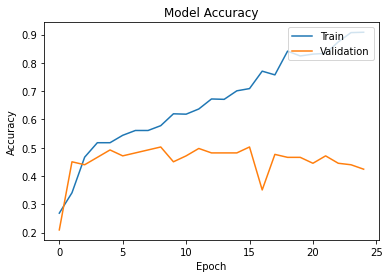

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
history2 = History()
model = create_model(64, 64, 128, 0.2, 0.001)
model.fit(X_train, y_bin, epochs=25, batch_size=32, verbose=1, shuffle=True,validation_split=0.2, callbacks=[history2])

Epoch 1/25
24/24 [==============================] - 22s 574ms/step - loss: 332.7532 - accuracy: 0.3159 - val_loss: 220.0052 - val_accuracy: 0.2042
Epoch 2/25
24/24 [==============================] - 10s 413ms/step - loss: 192.5411 - accuracy: 0.4181 - val_loss: 162.3851 - val_accuracy: 0.2199
Epoch 3/25
24/24 [==============================] - 10s 413ms/step - loss: 138.5751 - accuracy: 0.4692 - val_loss: 115.7187 - val_accuracy: 0.4084
Epoch 4/25
24/24 [==============================] - 10s 411ms/step - loss: 104.2917 - accuracy: 0.5059 - val_loss: 92.7813 - val_accuracy: 0.4398
Epoch 5/25
24/24 [==============================] - 10s 420ms/step - loss: 83.6979 - accuracy: 0.5046 - val_loss: 73.9635 - val_accuracy: 0.4293
Epoch 6/25
24/24 [==============================] - 10s 419ms/step - loss: 69.0759 - accuracy: 0.5426 - val_loss: 61.0726 - val_accuracy: 0.4450
Epoch 7/25
24/24 [==============================] - 10s 417ms/step - loss: 60.1385 - accuracy: 0.5203 - val_loss: 58.4236 -

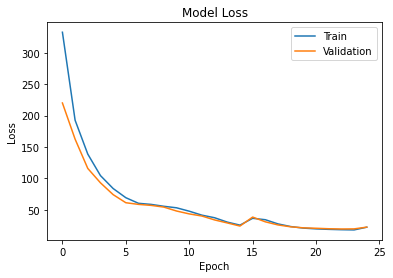

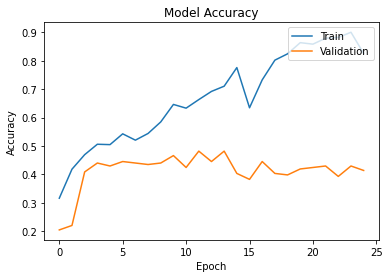

In [ ]:
plothist(history2)

In [ ]:
history3 = History()
model = create_model(16, 32, 512, 0.15, 0.0001)
model.fit(X_train, y_bin, epochs=20, batch_size=32, verbose=1, shuffle=True,validation_split=0.2, callbacks=[history3])

Epoch 1/20
24/24 [==============================] - 14s 308ms/step - loss: 377.1173 - accuracy: 0.2988 - val_loss: 82.0726 - val_accuracy: 0.4555
Epoch 2/20
24/24 [==============================] - 6s 229ms/step - loss: 80.5899 - accuracy: 0.5020 - val_loss: 76.8335 - val_accuracy: 0.4031
Epoch 3/20
24/24 [==============================] - 6s 232ms/step - loss: 72.5228 - accuracy: 0.5898 - val_loss: 68.2450 - val_accuracy: 0.4136
Epoch 4/20
24/24 [==============================] - 6s 230ms/step - loss: 63.6216 - accuracy: 0.7248 - val_loss: 59.9799 - val_accuracy: 0.4869
Epoch 5/20
24/24 [==============================] - 6s 230ms/step - loss: 55.6877 - accuracy: 0.8034 - val_loss: 53.2798 - val_accuracy: 0.4660
Epoch 6/20
24/24 [==============================] - 6s 231ms/step - loss: 49.0281 - accuracy: 0.9122 - val_loss: 47.0958 - val_accuracy: 0.4869
Epoch 7/20
24/24 [==============================] - 6s 230ms/step - loss: 43.1887 - accuracy: 0.9083 - val_loss: 41.9733 - val_accurac

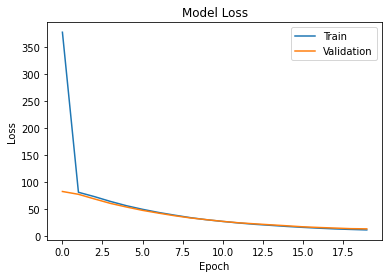

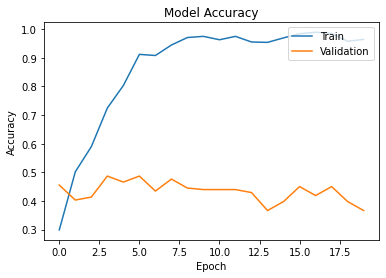

In [ ]:
plothist(history3)

Epoch 1/20
24/24 [==============================] - 11s 230ms/step - loss: 1099.6938 - accuracy: 0.3080 - val_loss: 560.0541 - val_accuracy: 0.4084
Epoch 2/20
24/24 [==============================] - 4s 156ms/step - loss: 424.0487 - accuracy: 0.4063 - val_loss: 310.9249 - val_accuracy: 0.4398
Epoch 3/20
24/24 [==============================] - 4s 156ms/step - loss: 247.8365 - accuracy: 0.4417 - val_loss: 188.6025 - val_accuracy: 0.4607
Epoch 4/20
24/24 [==============================] - 4s 160ms/step - loss: 167.3875 - accuracy: 0.4430 - val_loss: 145.6611 - val_accuracy: 0.4555
Epoch 5/20
24/24 [==============================] - 4s 156ms/step - loss: 132.1104 - accuracy: 0.4299 - val_loss: 124.6256 - val_accuracy: 0.4555
Epoch 6/20
24/24 [==============================] - 4s 157ms/step - loss: 114.7922 - accuracy: 0.4102 - val_loss: 109.5098 - val_accuracy: 0.4241
Epoch 7/20
24/24 [==============================] - 4s 163ms/step - loss: 106.6402 - accuracy: 0.4246 - val_loss: 103.4970

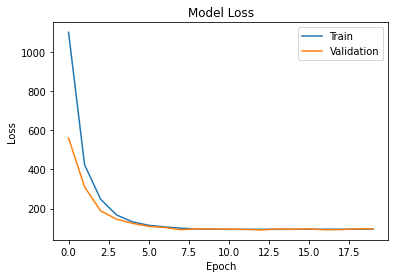

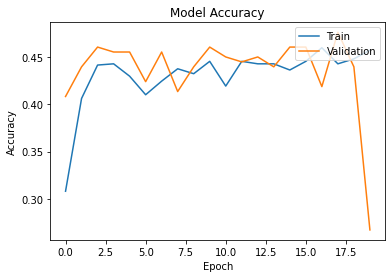

In [ ]:
history4 = History()
model = create_model(16, 16, 512, 0.2, 0.005)
model.fit(X_train, y_bin, epochs=20, batch_size=32, verbose=1, shuffle=True,validation_split=0.2, callbacks=[history4])
plothist(history4)

# Training non-aug

In [ ]:
def create_model_comp(num_filters_1, num_filters_2, num_filters_3, dense_units_1, dense_units_2, dropout_rate, l1_reg, learning_rate):
    model = Sequential()
    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_3, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units_1, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units_2, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
y_bin = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral',])
y_val_bin = label_binarize(y_val, classes=['angry', 'happy', 'sad', 'neutral',])


In [ ]:
specs.shape

(1218, 442, 382)

In [ ]:
history72 = History()
model = create_model_comp(32, 32, 32, 256, 256, 0.2, 0.002, 0.0001)
model.fit(X_train, y_bin, epochs=80, batch_size=32, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[history72])

Epoch 1/80
23/23 [==============================] - 14s 171ms/step - loss: 158.3163 - accuracy: 0.2863 - val_loss: 124.4133 - val_accuracy: 0.3989
Epoch 2/80
23/23 [==============================] - 2s 100ms/step - loss: 101.2862 - accuracy: 0.3945 - val_loss: 78.4124 - val_accuracy: 0.3989
Epoch 3/80
23/23 [==============================] - 2s 100ms/step - loss: 63.0563 - accuracy: 0.4205 - val_loss: 49.0816 - val_accuracy: 0.3989
Epoch 4/80
23/23 [==============================] - 2s 100ms/step - loss: 42.0178 - accuracy: 0.4356 - val_loss: 36.9739 - val_accuracy: 0.3989
Epoch 5/80
23/23 [==============================] - 2s 101ms/step - loss: 34.0301 - accuracy: 0.4233 - val_loss: 31.3254 - val_accuracy: 0.3989
Epoch 6/80
23/23 [==============================] - 3s 113ms/step - loss: 29.4158 - accuracy: 0.4521 - val_loss: 27.5400 - val_accuracy: 0.4536
Epoch 7/80
23/23 [==============================] - 2s 101ms/step - loss: 26.0879 - accuracy: 0.4685 - val_loss: 24.6335 - val_accur

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 0s 28ms/step - loss: 5.0033 - accuracy: 0.4230
Test accuracy: 0.4229508340358734
F1-score: 0.4264292113851392
              precision    recall  f1-score   support

           0       0.46      0.42      0.44        74
           1       0.19      0.27      0.23        48
           2       0.34      0.25      0.29        51
           3       0.55      0.55      0.55       132

    accuracy                           0.42       305
   macro avg       0.38      0.37      0.38       305
weighted avg       0.43      0.42      0.43       305



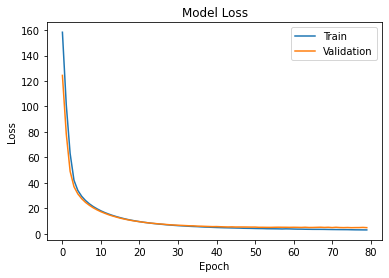

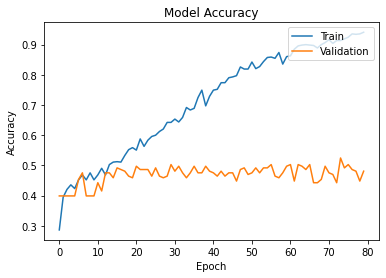

In [ ]:
plothist(history72)

In [ ]:
history72727 = History()
model = create_model_comp(32, 32, 32, 256, 256, 0.25, 0.003, 0.0002)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[history72727])

Epoch 1/40
23/23 [==============================] - 4s 122ms/step - loss: 198.1175 - accuracy: 0.3164 - val_loss: 117.2264 - val_accuracy: 0.4044
Epoch 2/40
23/23 [==============================] - 2s 102ms/step - loss: 80.8123 - accuracy: 0.3795 - val_loss: 57.9299 - val_accuracy: 0.4044
Epoch 3/40
23/23 [==============================] - 2s 102ms/step - loss: 48.2627 - accuracy: 0.4356 - val_loss: 40.3454 - val_accuracy: 0.3989
Epoch 4/40
23/23 [==============================] - 2s 102ms/step - loss: 36.0689 - accuracy: 0.4493 - val_loss: 32.0918 - val_accuracy: 0.3989
Epoch 5/40
23/23 [==============================] - 2s 102ms/step - loss: 29.4246 - accuracy: 0.4370 - val_loss: 26.8182 - val_accuracy: 0.3989
Epoch 6/40
23/23 [==============================] - 2s 102ms/step - loss: 24.9005 - accuracy: 0.4342 - val_loss: 23.0835 - val_accuracy: 0.4044
Epoch 7/40
23/23 [==============================] - 2s 103ms/step - loss: 21.6255 - accuracy: 0.4411 - val_loss: 20.1545 - val_accurac

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 0s 28ms/step - loss: 6.2214 - accuracy: 0.4721
Test accuracy: 0.4721311330795288
F1-score: 0.4477249351831595
              precision    recall  f1-score   support

           0       0.44      0.50      0.47        74
           1       0.24      0.17      0.20        48
           2       0.43      0.18      0.25        51
           3       0.55      0.68      0.61       132

    accuracy                           0.47       305
   macro avg       0.41      0.38      0.38       305
weighted avg       0.45      0.47      0.45       305



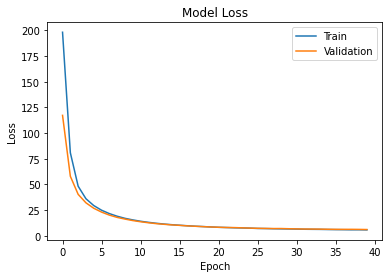

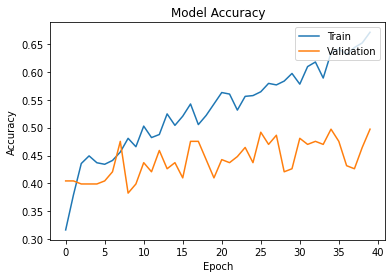

In [ ]:
plothist(history72727)

In [ ]:
history7a = History()
model = create_model_comp(32, 32, 32, 256, 256, 0.25, 0.003, 0.0002)
model.fit(X_train, y_bin, epochs=80, batch_size=32, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[history7a])

Epoch 1/80
23/23 [==============================] - 4s 124ms/step - loss: 208.2262 - accuracy: 0.2918 - val_loss: 136.6227 - val_accuracy: 0.3989
Epoch 2/80
23/23 [==============================] - 2s 102ms/step - loss: 100.8493 - accuracy: 0.4000 - val_loss: 75.8144 - val_accuracy: 0.3989
Epoch 3/80
23/23 [==============================] - 2s 102ms/step - loss: 62.9570 - accuracy: 0.4329 - val_loss: 51.5840 - val_accuracy: 0.3989
Epoch 4/80
23/23 [==============================] - 2s 102ms/step - loss: 44.5884 - accuracy: 0.4397 - val_loss: 38.0251 - val_accuracy: 0.3989
Epoch 5/80
23/23 [==============================] - 2s 102ms/step - loss: 33.6141 - accuracy: 0.4411 - val_loss: 29.4250 - val_accuracy: 0.3989
Epoch 6/80
23/23 [==============================] - 2s 104ms/step - loss: 26.4702 - accuracy: 0.4384 - val_loss: 23.6684 - val_accuracy: 0.3989
Epoch 7/80
23/23 [==============================] - 2s 104ms/step - loss: 21.6248 - accuracy: 0.4425 - val_loss: 19.6757 - val_accura

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 0s 31ms/step - loss: 5.0283 - accuracy: 0.4197
Test accuracy: 0.4196721315383911
F1-score: 0.4070366881415612
              precision    recall  f1-score   support

           0       0.43      0.54      0.48        74
           1       0.18      0.19      0.18        48
           2       0.32      0.14      0.19        51
           3       0.52      0.55      0.53       132

    accuracy                           0.42       305
   macro avg       0.36      0.35      0.35       305
weighted avg       0.41      0.42      0.41       305



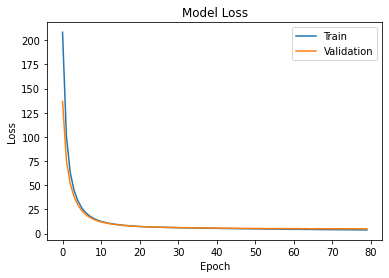

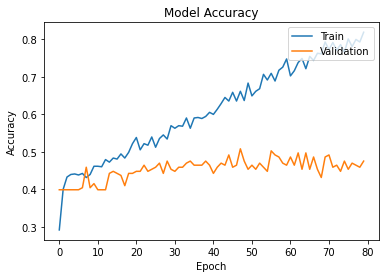

In [ ]:
plothist(history7a)

In [ ]:
history727a = History()
model = create_model_comp(32, 32, 32, 256, 256, 0.25, 0.003, 0.001)
model.fit(X_train, y_bin, epochs=40, batch_size=32, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[history727a])

Epoch 1/40
23/23 [==============================] - 4s 122ms/step - loss: 124.7547 - accuracy: 0.3589 - val_loss: 65.6791 - val_accuracy: 0.3989
Epoch 2/40
23/23 [==============================] - 2s 102ms/step - loss: 44.5162 - accuracy: 0.4178 - val_loss: 29.1649 - val_accuracy: 0.3989
Epoch 3/40
23/23 [==============================] - 2s 102ms/step - loss: 23.1026 - accuracy: 0.4315 - val_loss: 18.7292 - val_accuracy: 0.4044
Epoch 4/40
23/23 [==============================] - 2s 102ms/step - loss: 16.6205 - accuracy: 0.4370 - val_loss: 14.9700 - val_accuracy: 0.3989
Epoch 5/40
23/23 [==============================] - 2s 102ms/step - loss: 14.1758 - accuracy: 0.4329 - val_loss: 13.5778 - val_accuracy: 0.4044
Epoch 6/40
23/23 [==============================] - 2s 101ms/step - loss: 13.1682 - accuracy: 0.4397 - val_loss: 12.9046 - val_accuracy: 0.3989
Epoch 7/40
23/23 [==============================] - 2s 102ms/step - loss: 13.1680 - accuracy: 0.4356 - val_loss: 13.5962 - val_accuracy

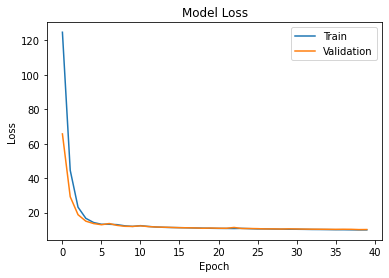

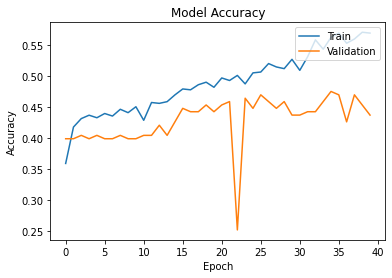

In [ ]:
plothist(history727a)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 0s 27ms/step - loss: 10.1643 - accuracy: 0.4721
Test accuracy: 0.4721311330795288
F1-score: 0.42144623446298424
              precision    recall  f1-score   support

           0       0.42      0.36      0.39        74
           1       0.25      0.02      0.04        48
           2       0.29      0.25      0.27        51
           3       0.54      0.78      0.64       132

    accuracy                           0.47       305
   macro avg       0.37      0.36      0.33       305
weighted avg       0.42      0.47      0.42       305



# Architectures/Functions



In [ ]:
def create_model1d(num_filters_1, dense_units, dropout_rate, l1_reg):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(221, 1537, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
def create_model_complex(num_filters_1, num_filters_2, num_filters_3, dense_units_1, dense_units_2, dropout_rate, l1_reg):
    model = Sequential()
    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(221, 1537, 1), kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_3, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units_1, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units_2, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
def create_model_comp(num_filters_1, num_filters_2, num_filters_3, dense_units_1, dense_units_2, dropout_rate, l1_reg, learning_rate):
    model = Sequential()
    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(221, 1537, 1), kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters_3, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units_1, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units_2, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
history727 = History()
model = create_model_comp(16, 16, 16, 256, 256, 0.2, 0.001, 0.00005)
model.fit(specs_aug, y_bin_aug, epochs=50, batch_size=32, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[history727])

Epoch 1/50
35/35 [==============================] - 9s 221ms/step - loss: 87.7716 - accuracy: 0.2349 - val_loss: 72.6917 - val_accuracy: 0.4031
Epoch 2/50
35/35 [==============================] - 7s 201ms/step - loss: 65.2717 - accuracy: 0.2422 - val_loss: 57.3690 - val_accuracy: 0.3979
Epoch 3/50
35/35 [==============================] - 7s 202ms/step - loss: 51.6499 - accuracy: 0.2523 - val_loss: 45.7118 - val_accuracy: 0.3979
Epoch 4/50
35/35 [==============================] - 7s 203ms/step - loss: 41.7708 - accuracy: 0.2715 - val_loss: 37.8463 - val_accuracy: 0.3979
Epoch 5/50
35/35 [==============================] - 7s 204ms/step - loss: 35.6798 - accuracy: 0.2596 - val_loss: 33.8739 - val_accuracy: 0.2356
Epoch 6/50
35/35 [==============================] - 7s 204ms/step - loss: 33.0114 - accuracy: 0.2212 - val_loss: 31.8469 - val_accuracy: 0.3979
Epoch 7/50
35/35 [==============================] - 7s 204ms/step - loss: 30.9852 - accuracy: 0.2468 - val_loss: 29.9973 - val_accuracy:

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

10/10 [==============================] - 0s 32ms/step - loss: 5.7877 - accuracy: 0.4245
Test accuracy: 0.4245283007621765
F1-score: 0.36517501383550605
[[26  0  5 40  0  0]
 [23  0  2 33  0  0]
 [ 1  0 14 26  0  0]
 [17  0 25 95  0  0]
 [ 0  0  0  1  0  0]
 [ 2  0  0  8  0  0]]


In [ ]:
history6 = History()
model = create_model_complex(16, 16, 16, 256, 256, 0.2, 0.001)
model.fit(specs_aug, y_bin_aug, epochs=20, batch_size=32, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[history6])

Epoch 1/20
35/35 [==============================] - 11s 240ms/step - loss: 50.0879 - accuracy: 0.2358 - val_loss: 27.3432 - val_accuracy: 0.3979
Epoch 2/20
35/35 [==============================] - 7s 201ms/step - loss: 21.8866 - accuracy: 0.3789 - val_loss: 17.7538 - val_accuracy: 0.3455
Epoch 3/20
35/35 [==============================] - 7s 201ms/step - loss: 15.0932 - accuracy: 0.4651 - val_loss: 13.0583 - val_accuracy: 0.3770
Epoch 4/20
35/35 [==============================] - 7s 203ms/step - loss: 11.5652 - accuracy: 0.5431 - val_loss: 10.3916 - val_accuracy: 0.4817
Epoch 5/20
35/35 [==============================] - 7s 203ms/step - loss: 9.4300 - accuracy: 0.5550 - val_loss: 9.0928 - val_accuracy: 0.3717
Epoch 6/20
35/35 [==============================] - 7s 203ms/step - loss: 8.2801 - accuracy: 0.6000 - val_loss: 8.9243 - val_accuracy: 0.4974
Epoch 7/20
35/35 [==============================] - 7s 207ms/step - loss: 7.8388 - accuracy: 0.6303 - val_loss: 7.5754 - val_accuracy: 0.43

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(confusion_matrix(y_arg, y_pred))

10/10 [==============================] - 0s 33ms/step - loss: 6.3153 - accuracy: 0.4340
Test accuracy: 0.43396225571632385
F1-score: 0.3944528605117428
[[22 14  4 44  0  0]
 [12  7  8 25  0  0]
 [ 2  1 12 33  0  0]
 [ 9 11 10 97  0  0]
 [ 0  0  0  2  0  0]
 [ 1  1  1  2  0  0]]


In [ ]:
history7 = History()
model = create_model(16, 16, 256, 0.2, 0.002)
model.fit(specs_aug, y_bin_aug, epochs=20, batch_size=32, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[history7])

Epoch 1/20
35/35 [==============================] - 7s 144ms/step - loss: 413.4056 - accuracy: 0.3165 - val_loss: 180.6600 - val_accuracy: 0.4555
Epoch 2/20
35/35 [==============================] - 4s 123ms/step - loss: 139.9375 - accuracy: 0.4248 - val_loss: 106.0316 - val_accuracy: 0.3508
Epoch 3/20
35/35 [==============================] - 4s 122ms/step - loss: 82.8754 - accuracy: 0.4798 - val_loss: 63.5229 - val_accuracy: 0.4503
Epoch 4/20
35/35 [==============================] - 4s 124ms/step - loss: 52.3768 - accuracy: 0.4917 - val_loss: 43.9351 - val_accuracy: 0.2670
Epoch 5/20
35/35 [==============================] - 4s 122ms/step - loss: 35.9397 - accuracy: 0.5349 - val_loss: 30.0878 - val_accuracy: 0.2775
Epoch 6/20
35/35 [==============================] - 4s 123ms/step - loss: 26.1156 - accuracy: 0.5202 - val_loss: 23.9872 - val_accuracy: 0.4136
Epoch 7/20
35/35 [==============================] - 4s 125ms/step - loss: 21.6258 - accuracy: 0.5422 - val_loss: 20.9090 - val_accur

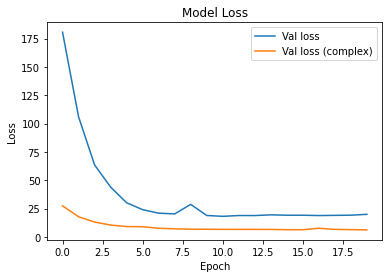

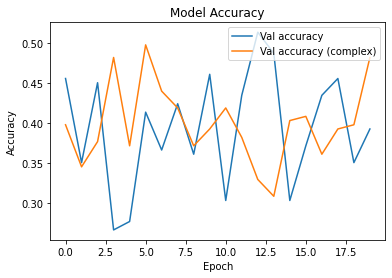

In [ ]:
plt.plot(history7.history['val_loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Val loss', 'Val loss (complex)'], loc='upper right')
plt.show()

plt.plot(history7.history['val_accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val accuracy', 'Val accuracy (complex)'], loc='upper right')
plt.show()

In [ ]:
history727 = History()
model = create_model_comp(16, 16, 16, 256, 256, 0.2, 0.001, 0.0001)
model.fit(specs_aug, y_bin_aug, epochs=50, batch_size=32, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[history727])

Epoch 1/50
29/29 [==============================] - 15s 176ms/step - loss: 86.3562 - accuracy: 0.2625 - val_loss: 60.9855 - val_accuracy: 0.2295
Epoch 2/50
29/29 [==============================] - 3s 114ms/step - loss: 50.5028 - accuracy: 0.2963 - val_loss: 40.7745 - val_accuracy: 0.4372
Epoch 3/50
29/29 [==============================] - 3s 114ms/step - loss: 35.7908 - accuracy: 0.3126 - val_loss: 32.7739 - val_accuracy: 0.1421
Epoch 4/50
29/29 [==============================] - 3s 115ms/step - loss: 30.7764 - accuracy: 0.2865 - val_loss: 29.2209 - val_accuracy: 0.4372
Epoch 5/50
29/29 [==============================] - 3s 115ms/step - loss: 28.1375 - accuracy: 0.3366 - val_loss: 26.9537 - val_accuracy: 0.1967
Epoch 6/50
29/29 [==============================] - 3s 116ms/step - loss: 25.9827 - accuracy: 0.3301 - val_loss: 24.9659 - val_accuracy: 0.4372
Epoch 7/50
29/29 [==============================] - 3s 116ms/step - loss: 24.1650 - accuracy: 0.3224 - val_loss: 23.2770 - val_accuracy

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 0s 33ms/step - loss: 4.7768 - accuracy: 0.4262
Test accuracy: 0.4262295067310333
F1-score: 0.3813436565577871
              precision    recall  f1-score   support

           0       0.35      0.61      0.45        62
           1       0.17      0.08      0.11        64
           2       0.36      0.09      0.15        53
           3       0.53      0.65      0.59       126

    accuracy                           0.43       305
   macro avg       0.35      0.36      0.32       305
weighted avg       0.39      0.43      0.38       305

